In [1]:
import math
import torch
import gpytorch
import numpy as np
import numpy.linalg as linalg

import spectralgp
from spectralgp.samplers import AlternatingSampler
from spectralgp.models import ExactGPModel, SpectralModel, ProductKernelSpectralModel
from spectralgp.sampling_factories import ss_factory, ess_factory
from sklearn import datasets

import argparse

import sys
import matplotlib.pyplot as plt

import traceback

torch.set_default_dtype(torch.float64)

In [2]:

nomg = 100
ess_iters = 10
optim_iters = 1
iters = 10
omega_max = 8.
nclusters = 2
shared = "False"
in_dims = 2
torch.random.manual_seed(42)


In [3]:
#x_messy, _ = datasets.make_classification(n_samples=200,
#                                         n_features=in_dims,
#                                          n_classes= nclusters,
#                                          n_clusters_per_class=1,
#                                          class_sep=0.4,
#                                          shuffle=False,
#                                          random_state=301)

#x_messy, _ = datasets.make_circles(n_samples=50, shuffle=True, noise=0.3, random_state=None, factor=0.2)
x_messy, _ = datasets.make_moons(n_samples=100, noise=.05)
x_messy = torch.from_numpy(x_messy)

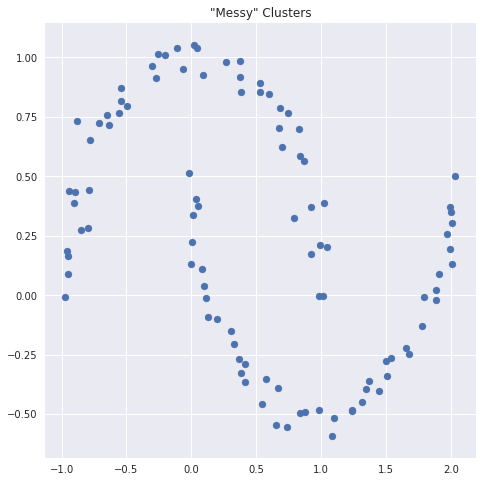

In [4]:
train_x = x_messy
test_x = x_messy

plt.style.use('seaborn')
cmap = 'tab10'

plt.figure(figsize=(17,8))
plt.subplot(121, title='"Messy" Clusters')
plt.scatter(x_messy[:,0], x_messy[:,1])


0
tensor(8.)


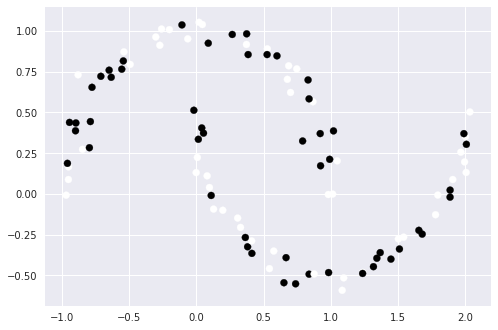

Step:  0 Dimension:  0
Loss is:  tensor(-74.7911, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 0


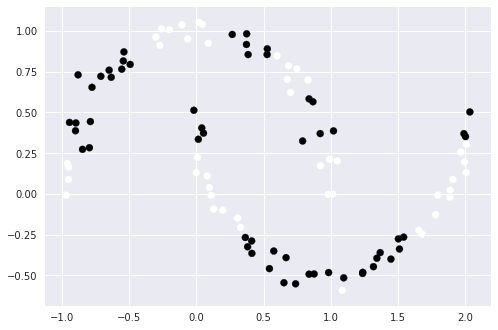

Step:  0 Dimension:  1
Loss is:  tensor(-120.5335, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 0


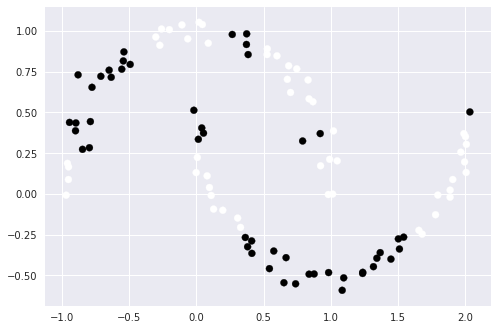

Seconds for Iteration 0 : 2.1755049228668213
Step:  1 Dimension:  0
Loss is:  tensor(-115.3449, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 1


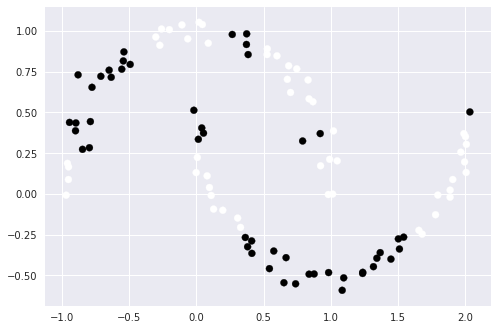

Step:  1 Dimension:  1
Loss is:  tensor(-115.0808, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 1


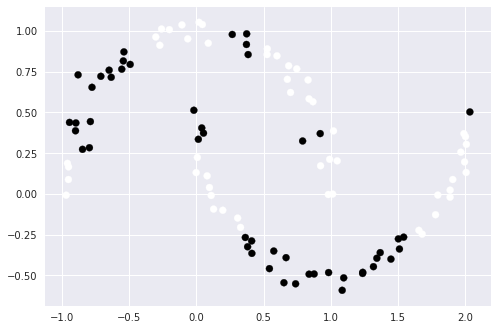

Seconds for Iteration 1 : 2.4549896717071533
Step:  2 Dimension:  0
Loss is:  tensor(-101.8691, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 2


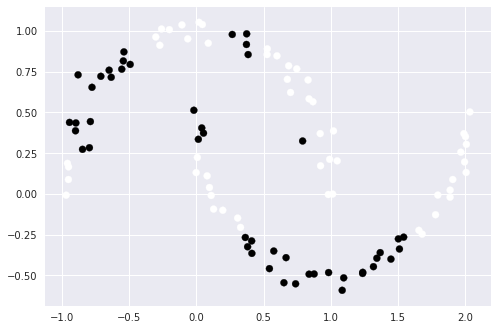

Step:  2 Dimension:  1
Loss is:  tensor(-97.0605, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 2


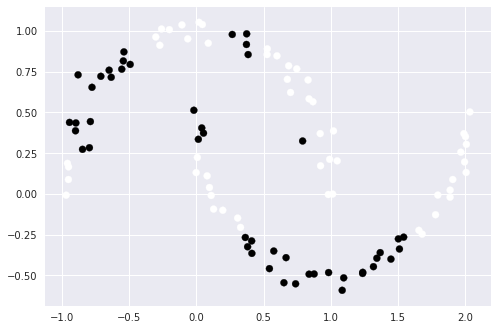

Seconds for Iteration 2 : 2.3189773559570312
Step:  3 Dimension:  0
Loss is:  tensor(-100.1009, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 3


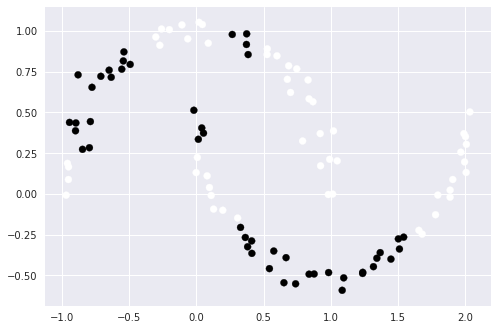

Step:  3 Dimension:  1
Loss is:  tensor(-103.0627, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 3


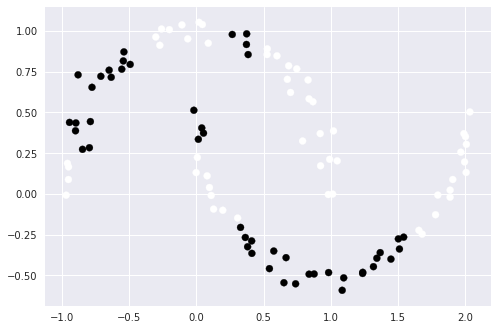

Seconds for Iteration 3 : 2.4739906787872314
Step:  4 Dimension:  0
Loss is:  tensor(-104.9578, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 4


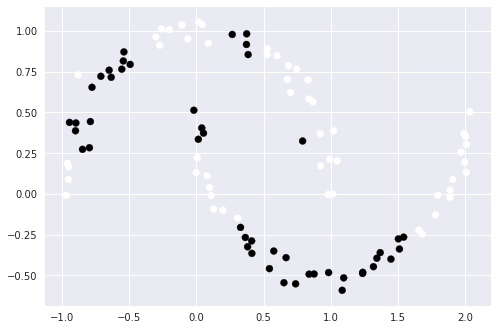

Step:  4 Dimension:  1
Loss is:  tensor(-105.5851, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 4


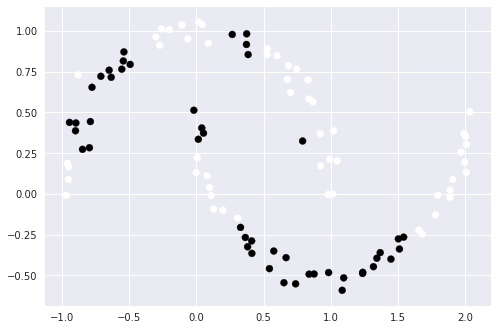

Seconds for Iteration 4 : 3.1633663177490234
Step:  5 Dimension:  0
Loss is:  tensor(-93.2828, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 5


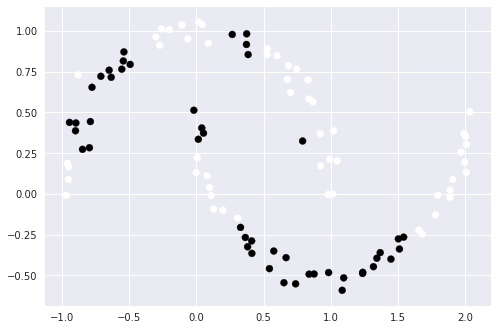

Step:  5 Dimension:  1
Loss is:  tensor(-92.4672, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 5


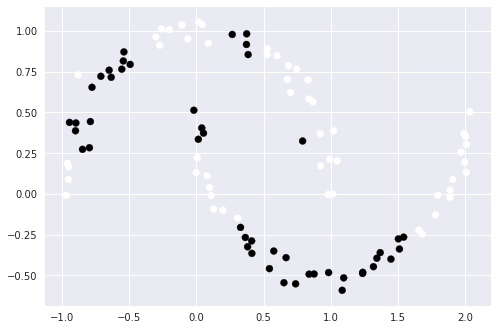

Seconds for Iteration 5 : 2.8780791759490967
Step:  6 Dimension:  0
Loss is:  tensor(-92.4035, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 6


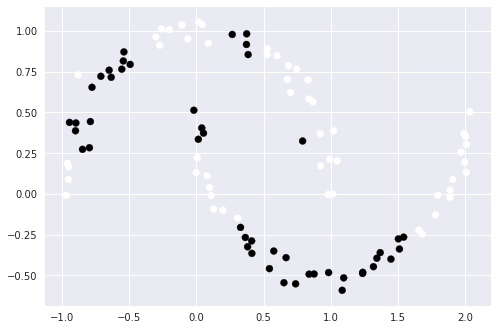

Step:  6 Dimension:  1
Loss is:  tensor(-91.3401, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 6


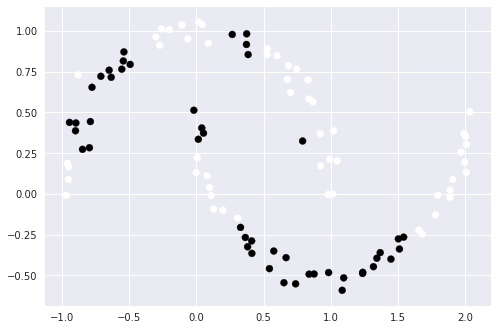

Seconds for Iteration 6 : 3.090068817138672
Step:  7 Dimension:  0
Loss is:  tensor(-93.5381, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 7


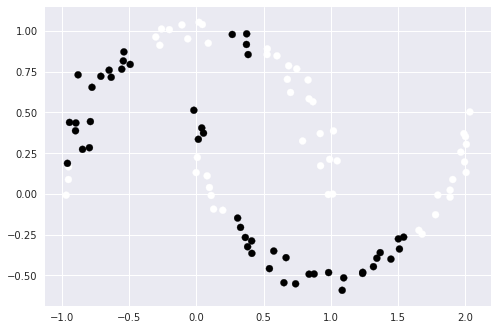

Step:  7 Dimension:  1
Loss is:  tensor(-101.7301, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 7


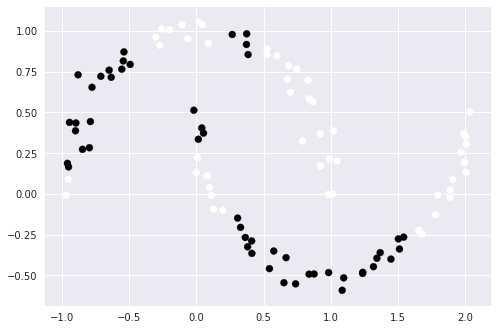

Seconds for Iteration 7 : 2.925699472427368
Step:  8 Dimension:  0
Loss is:  tensor(-98.6505, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 8


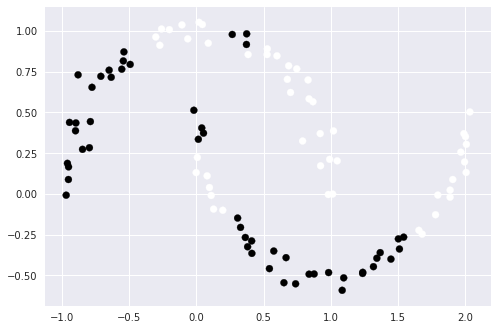

Step:  8 Dimension:  1
Loss is:  tensor(-104.9322, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 8


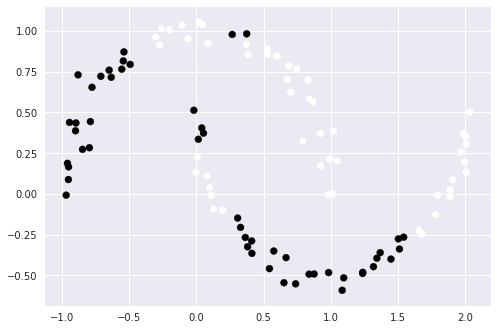

Seconds for Iteration 8 : 2.8437390327453613
Step:  9 Dimension:  0
Loss is:  tensor(-111.9411, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 9


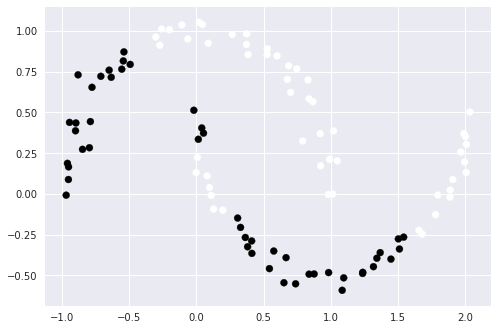

Step:  9 Dimension:  1
Loss is:  tensor(-101.1680, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 9


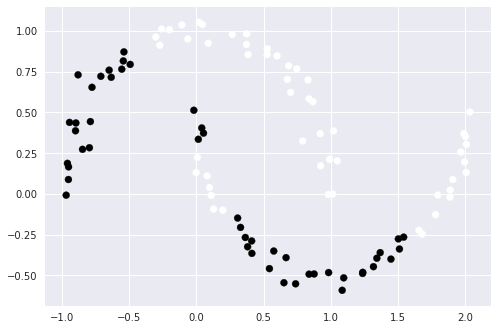

Seconds for Iteration 9 : 2.035447359085083
tensor([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1])


In [5]:
data_mod = spectralgp.models.FKL_KKM(train_x, None, nclusters, shared=shared,
        normalize = False, symmetrize = False, num_locs = nomg, spacing='random', pretrain=False, omega_max = omega_max, nonstat = True)

################################
## set up alternating sampler ##
################################

alt_sampler = spectralgp.samplers.AlternatingSampler(
[data_mod],
spectralgp.sampling_factories.ss_factory, [spectralgp.sampling_factories.ess_factory],
totalSamples=iters, numInnerSamples=ess_iters, numOuterSamples=optim_iters, num_dims=in_dims
)
alt_sampler.run()

print(data_mod.labels_)

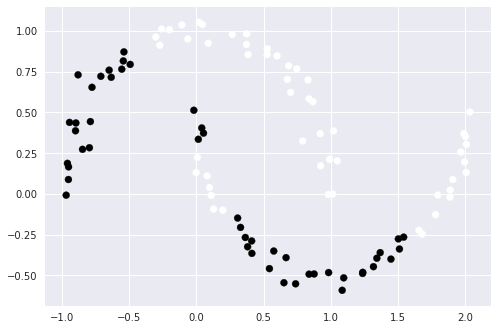

In [6]:
plt.scatter(x_messy[:,0], x_messy[:,1], c=data_mod.labels_)